# Individual part LOF and N-Gram

## Group Number : 42

## Student 1 
### Name : Otte van Dam
### ID : 5096790

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat
from sklearn.neighbors import LocalOutlierFactor
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import sys

nb = nbformat.read("LOF_Ngram.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 401


## 1. Familiarization task – 1 A4

In [2]:
data = "train_data.csv"
df1 = pd.read_csv(data)

val_data = "val_data.csv"
validation_data = pd.read_csv(val_data)

## 2. LOF task – 1/2 A4 – Individual

### 2a. Plot LOF scores

In [3]:
clf = LocalOutlierFactor(n_neighbors=50)
df1_lof = df1[['LIT301', 'LIT101', 'MV101']]
y_pred = clf.fit_predict(df1_lof)
del df1_lof
indexes_outliers = []
for i in range(len(y_pred)):
    if y_pred[i] == -1:
        indexes_outliers.append(i)

outliers = df1.iloc[indexes_outliers]
del indexes_outliers
outliers = outliers['Id']

y_pred_negative = [y_pred[i] for i in outliers]
y_pred_positive = [y_pred[i] for i in df1['Id'] if i not in outliers]
del y_pred

timestamps = df1['Timestamp']
timestamps_negative = [datetime.strptime(timestamps[i].strip(), '%d/%m/%Y %I:%M:%S %p') for i in outliers]
postive_indexes = range(len(df1))
timestamps_positive = [datetime.strptime(timestamps[i].strip(), '%d/%m/%Y %I:%M:%S %p') for i in df1['Id'] if i not in outliers]
del outliers
del timestamps

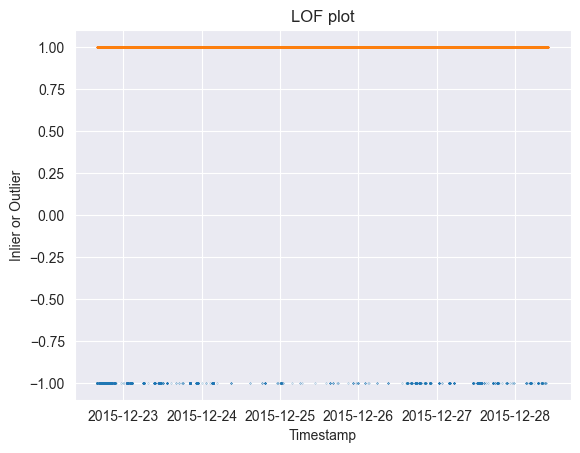

In [4]:
# Create scatter plot with fewer datapoints to keep it lighter for your computer :)
plt.scatter(timestamps_negative[::2], y_pred_negative[::2], s=0.03)
plt.scatter(timestamps_positive[::50], y_pred_positive[::50], s=0.03)
# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Inlier or Outlier')
plt.title('LOF plot')

plt.rcParams['figure.figsize'] = [14, 8]


plt.show()

### 2b. Analysis and answers to the questions
The default number of neighbours used for LOF is 20 but since we have a very large dataset and anomalies can take up more datapoints, I have chosen for a value 50. There are a lot of anomalies detected at the start which is to be expected since that is when the system is starting up. LOF is good at detecting point anomalies since it compares points with other points and the distance between them.

In [5]:
del y_pred_negative
del y_pred_positive
del timestamps_positive
del timestamps_negative

## 5. N-gram task – 1/2 A4 - Individual

In [6]:
def generate_n_gram_table(series, n_gram_length, M):
    # Create a list to store the n-gram tuples
    n_grams = []
    n_grams_set = set()
    # Generate n-gram tuples from the series
    for i in tqdm(range(len(series) - n_gram_length + 1)):
        n_gram = tuple(series[i:i+n_gram_length])
        if n_gram not in n_grams_set:
            n_grams.append(n_gram)
            n_grams_set.add(n_gram)

    # Create a list to store the table rows
    table = []

    # Iterate over the series with step size M
    for i in tqdm(range(0, len(series), M)):
        row = [0] * len(n_grams)
        subseries = series.iloc[i:i+M]
        n_gram_dict_window = {}
        # Count the frequency of each n-gram in the subseries
        for j in range(len(subseries) - n_gram_length + 1):
            n_gram = tuple(subseries[j:j+n_gram_length])
            if n_gram not in n_gram_dict_window:
                n_gram_dict_window[n_gram] = 0
            n_gram_dict_window[n_gram] += 1
        # Create the row for in the table
        for k, n_gram in enumerate(n_grams):
            if n_gram in n_gram_dict_window:
                row[k] = n_gram_dict_window[n_gram]
        table.append(row)

    return table, n_grams

In [7]:
df1_ngram = df1.copy()
# Strip leading spaces from 'timestamps' column
df1_ngram['Timestamp'] = df1_ngram['Timestamp'].str.strip()

# Convert 'timestamps' column to datetime objects
df1_ngram['Timestamp'] = pd.to_datetime(df1_ngram['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

#differencing
df1_ngram['differenced_LIT301'] = df1_ngram['LIT301'].diff()
df1_ngram['differenced_LIT301'] = pd.qcut(df1_ngram['LIT301'], 15, labels=False)

In [8]:
def run_ngram(values, value_name, n_gram_length, M, threshold):
    # Generate n-gram table
    table, n_grams = generate_n_gram_table(values, n_gram_length, M)
    # Get the similarity of every row to each other row
    sim_table = cosine_similarity(table)
    # Get the average similarity of each row
    avg_similarities = np.mean(sim_table, axis=1)

    # Identify outliers in the data
    anomalies = []
    for i in range(len(avg_similarities)):
        if avg_similarities[i] < threshold:
            anomalies.append(i)
    print(anomalies)

    # Set values to original value for plotting
    values = df1_ngram[value_name]
    timestamps = df1_ngram['Timestamp']

    plt.rcParams['figure.figsize'] = [14, 8]

    # Plot the values
    plt.plot(timestamps, values, color='blue')
    anomaly_points = []
    # Highlight anomalies with a different color
    for idx in anomalies:
        if idx * M + M > len(timestamps):
            anomaly_points += [i for i in range(idx * M, len(timestamps) - 1)]
        else:
            anomaly_points += [i for i in range(idx * M, idx * M + M)]
    plt.scatter(timestamps[anomaly_points], values[anomaly_points], label='Predicted Anomalies')
    del anomalies
    # Add labels and title
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('Plot with Anomalies of value ' + value_name)
    plt.legend()

    # Show the plot
    plt.show()
    del values
    del timestamps
    return table, n_grams

## Without differencing

100%|██████████| 119/119 [00:16<00:00,  7.29it/s]


[0, 1, 2, 3, 16, 17, 118]


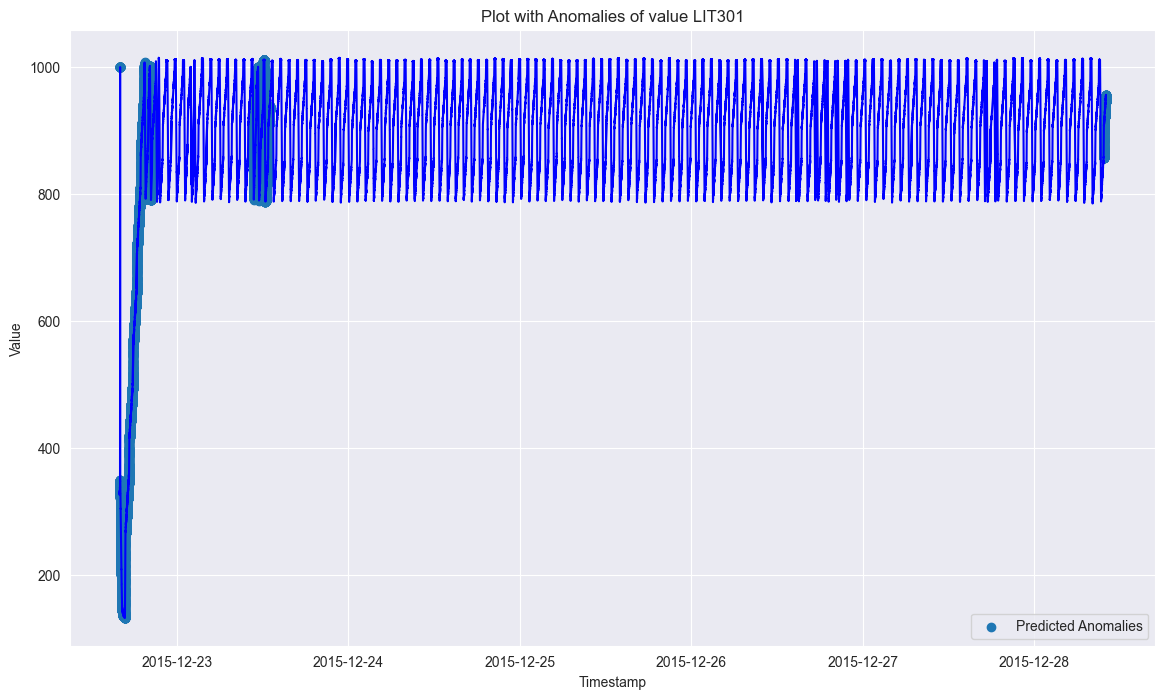

In [9]:
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['LIT301'], 15, labels=False)

# Variables for the ngram table
values = df1_ngram['bin']
table, n_grams = run_ngram(values, 'LIT301', 3, 4200, 0.78)

## With differencing

100%|██████████| 119/119 [00:16<00:00,  7.43it/s]


[0, 1, 2, 3, 16, 17, 118]


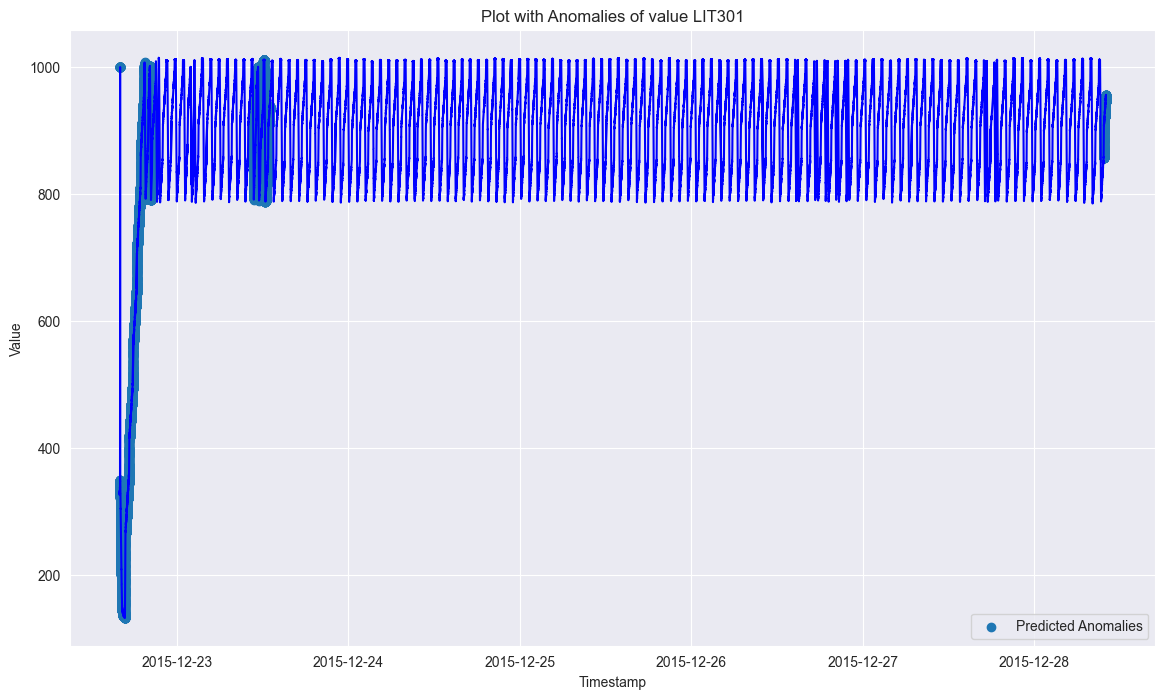

([[4141,
   1,
   1,
   53,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [4198,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [10]:
#differencing
df1_ngram['differenced_LIT301'] = df1_ngram['LIT301'].diff()
values = pd.qcut(df1_ngram['LIT301'], 15, labels=False)

run_ngram(values, 'LIT301', 3, 4200, 0.78)

### Running on unseen data

100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


[1, 2, 22, 23, 24, 31, 41, 47, 53]


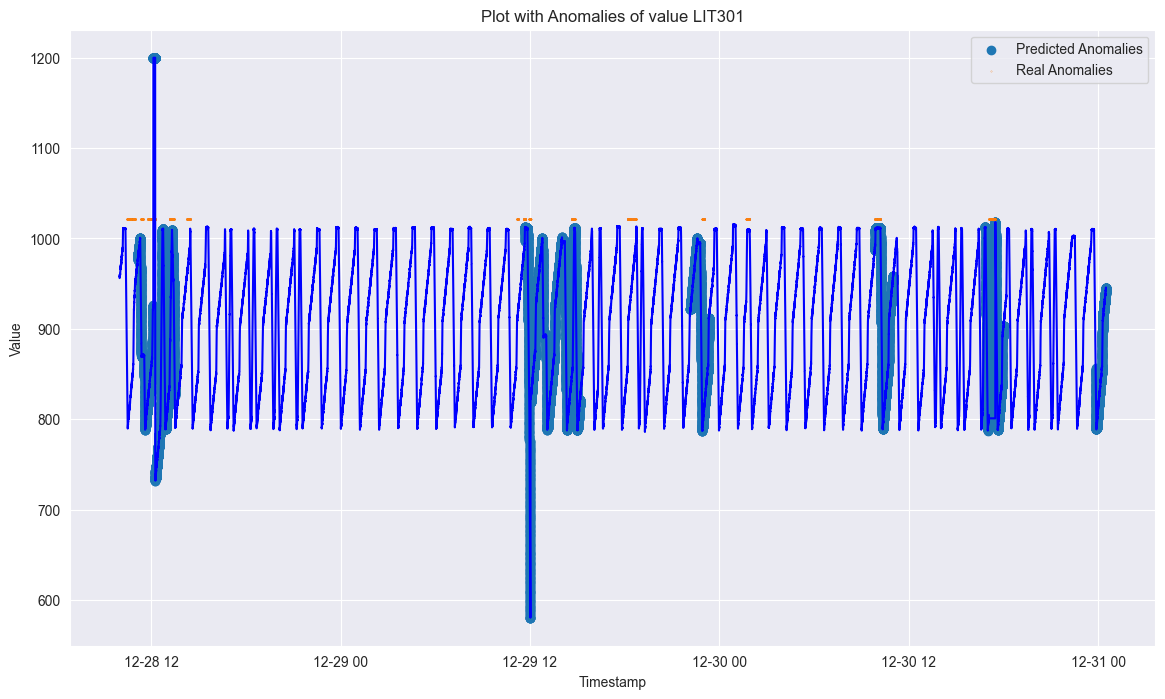

In [11]:
# Preprocess the new unseen data
new_data = validation_data.copy()
new_data['Timestamp'] = new_data['Timestamp'].str.strip()
new_data['Timestamp'] = pd.to_datetime(new_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

bins = df1_ngram['bin']
# Compute the bin edges
unique_bins = np.unique(bins)
bin_edges = []
previous_max = None
for bin_num in unique_bins:
    bin_values = df1_ngram['LIT301'][bins == bin_num]
    bin_min = bin_values.min()
    if previous_max is not None:
        bin_edge = (previous_max + bin_min) / 2
        bin_edges.append(bin_edge)
    previous_max = bin_values.max()
bin_edges.append(previous_max)


def find_index(list_values, value):
    for i, val in enumerate(list_values):
        if val > value:
            return i
    return 14


binned_values = []
for value in new_data['LIT301']:
    binned_values.append(find_index(bin_edges, value))
new_data['bin'] = pd.Series(binned_values)
series = new_data['bin']
M = 4200
n_gram_length = 3
# Create a list to store the table rows
table_new_data = []

# Iterate over the series with step size M
for i in tqdm(range(0, len(series), M)):
    row = [0] * len(n_grams)
    subseries = series.iloc[i:i + M]
    n_gram_dict_window = {}
    # Count the frequency of each n-gram in the subseries
    for j in range(len(subseries) - n_gram_length + 1):
        n_gram = tuple(subseries[j:j + n_gram_length])
        if n_gram not in n_gram_dict_window:
            n_gram_dict_window[n_gram] = 0
        n_gram_dict_window[n_gram] += 1
    for k, n_gram in enumerate(n_grams):
        if n_gram in n_gram_dict_window:
            row[k] = n_gram_dict_window[n_gram]

    table_new_data.append(row)

# Calculate the cosine similarity between each row in table_new_data and all the rows in table
cosine_similarities = cosine_similarity(table_new_data, table)

# Calculate the average cosine similarity for each row in table_new_data
average_similarities = cosine_similarities.mean(axis=1)

# Identify outliers in the data
anomalies = []
for i in range(len(average_similarities)):
    if average_similarities[i] < 0.78:
        anomalies.append(i)
print(anomalies)

# Set values to original value for plotting
values = new_data['LIT301']
timestamps = new_data['Timestamp']

plt.rcParams['figure.figsize'] = [14, 8]

# Plot the values
plt.plot(timestamps, values, color='blue')
anomaly_points = []
# Highlight anomalies with a different color
for idx in anomalies:
    if idx * M + M > len(timestamps):
        anomaly_points += [i for i in range(idx * M, len(timestamps) - 1)]
    else:
        anomaly_points += [i for i in range(idx * M, idx * M + M)]
plt.scatter(timestamps[anomaly_points], values[anomaly_points], label='Predicted Anomalies')
validation_data_anomalies = validation_data[validation_data['Label'] == 1]
plt.scatter([datetime.strptime(timestamp.strip(), '%d/%m/%Y %I:%M:%S %p') for timestamp in validation_data_anomalies['Timestamp'][::2]],  validation_data_anomalies['Label'][::2] + 1020, s=0.03, label='Real Anomalies')
del anomalies
# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Plot with Anomalies of value LIT301')
plt.legend()

# Show the plot
plt.show()

### 5a. Visualise discretization

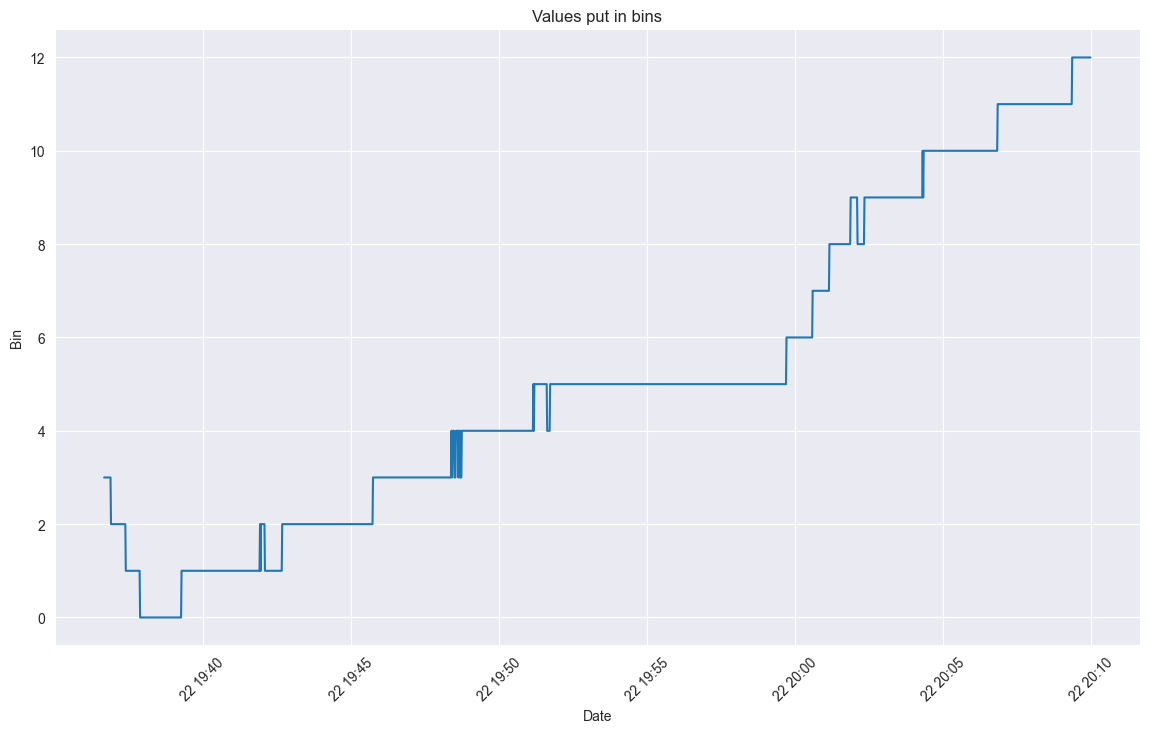

In [12]:
# Sort the DataFrame by 'Timestamp' column
df1_ngram = df1_ngram.sort_values('Timestamp')

# Create the line plot
plt.plot(df1_ngram['Timestamp'][13000:15000], df1_ngram['bin'][13000:15000])

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Bin')
plt.title('Values put in bins')

# Rotate x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### 5b. Analysis and answers to the questions. Also provide relevant plots.

### Difference of differencing
Differencing gives the exact same windows as anomalies so there is no difference found with differencing in this case.
### Types of anomalies
The detected anomalies are windows that are dissimilar to the other windows. These are best to be removed when training a model since this might lead to false negatives. The length of the n-grams are set to 3 since most values just repeat itself very often before going to the next bin. Having a n-gram of more would just add more storage. The window size is set to 4200 since the cyclic behaviour repeats about every 70 minutes. This way every window stands for one cycle and those cycles can then be compared to each other.
### Residuals
The ngram can predict anomalies well but it counts a whole window as an anomaly and therefor has to many points as anomalies. In real life this is however fine because then you just want to know if there is an anomaly or not and the exact datapoints don't matter as much anymore

## Trying on other sensors

100%|██████████| 119/119 [00:15<00:00,  7.67it/s]


[0, 1, 2, 3, 4, 8, 16, 17, 81, 83, 87, 100, 118]


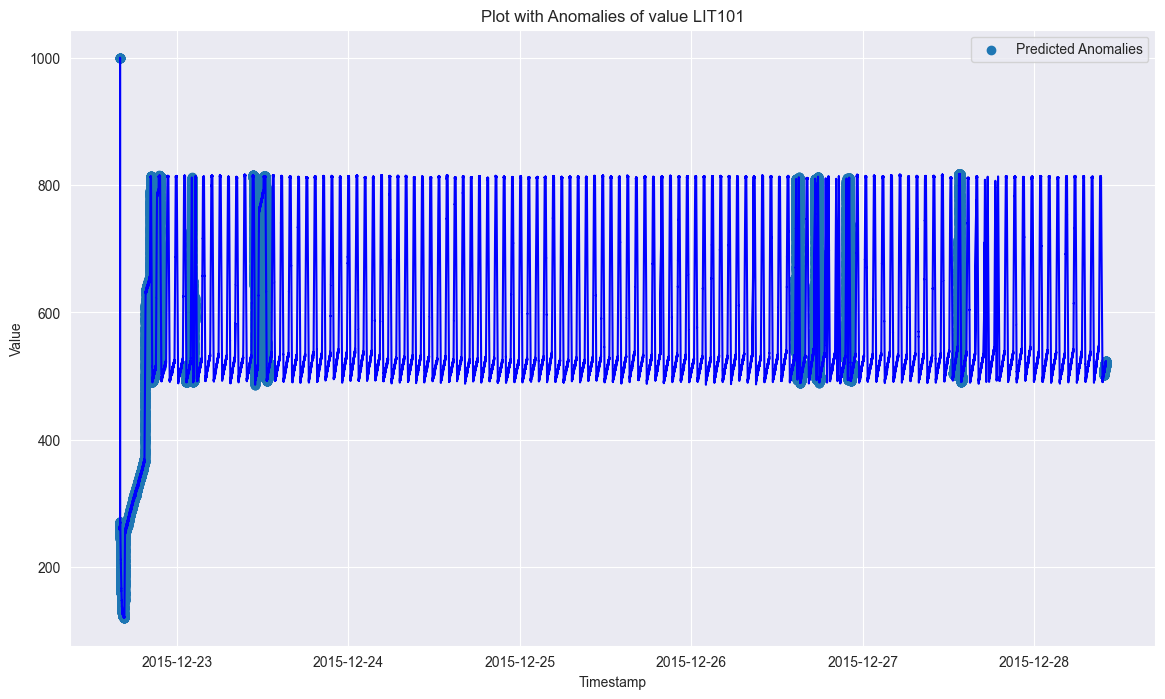

([[4178,
   1,
   1,
   16,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [4198,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [13]:
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['LIT101'], 15, labels=False)

# Variables for the ngram table
values = df1_ngram['bin']
run_ngram(values, 'LIT101', 3, 4200, 0.78)

100%|██████████| 119/119 [00:15<00:00,  7.54it/s]


[]


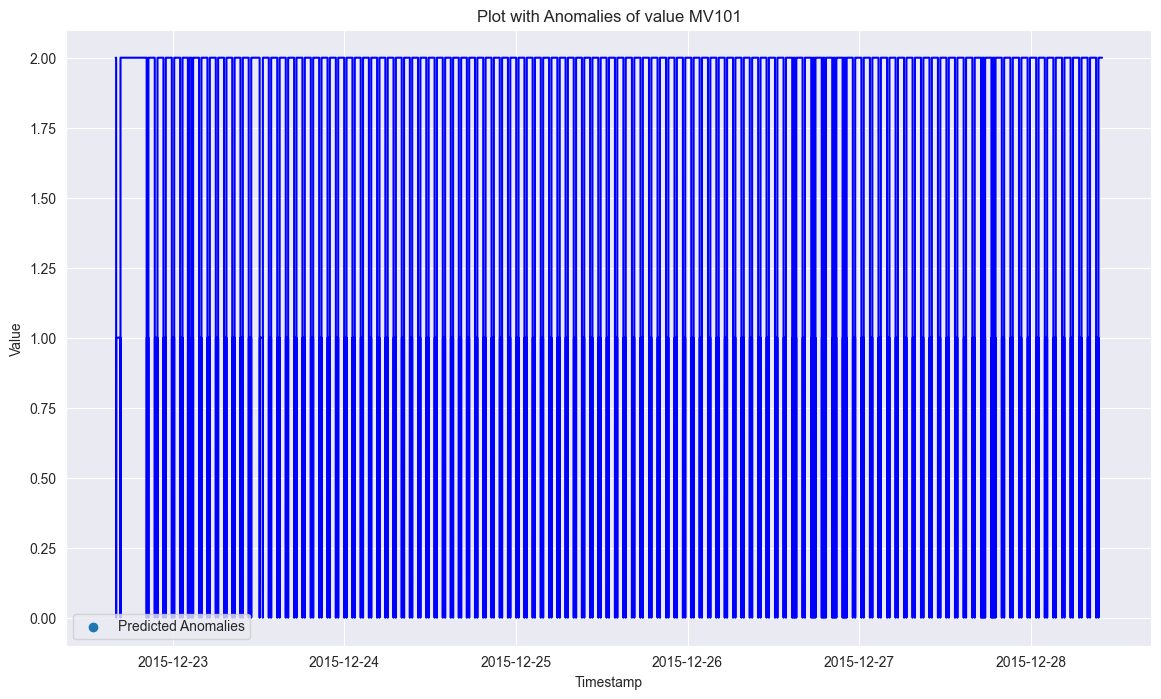

([[1998, 1, 1, 2196, 1, 1],
  [4198, 0, 0, 0, 0, 0],
  [4198, 0, 0, 0, 0, 0],
  [3312, 1, 1, 882, 1, 1],
  [2864, 1, 1, 1332, 0, 0],
  [2998, 1, 1, 1196, 1, 1],
  [3024, 1, 1, 1170, 1, 1],
  [2982, 1, 1, 1212, 1, 1],
  [3458, 1, 1, 734, 2, 2],
  [3359, 2, 2, 833, 1, 1],
  [3013, 1, 1, 1181, 1, 1],
  [2996, 1, 1, 1198, 1, 1],
  [2973, 1, 1, 1221, 1, 1],
  [2920, 1, 1, 1274, 1, 1],
  [2937, 1, 1, 1257, 1, 1],
  [2955, 1, 1, 1239, 1, 1],
  [3145, 0, 0, 1051, 1, 1],
  [2571, 1, 1, 1623, 1, 1],
  [3004, 1, 1, 1190, 1, 1],
  [2990, 1, 1, 1204, 1, 1],
  [2987, 1, 1, 1207, 1, 1],
  [3014, 1, 1, 1180, 1, 1],
  [2994, 1, 1, 1200, 1, 1],
  [3001, 1, 1, 1193, 1, 1],
  [3007, 1, 1, 1187, 1, 1],
  [3012, 1, 1, 1182, 1, 1],
  [2998, 1, 1, 1196, 1, 1],
  [3021, 1, 1, 1173, 1, 1],
  [3008, 1, 1, 1186, 1, 1],
  [3020, 1, 1, 1174, 1, 1],
  [3022, 1, 1, 1172, 1, 1],
  [3014, 1, 1, 1180, 1, 1],
  [3010, 1, 1, 1184, 1, 1],
  [3017, 1, 1, 1177, 1, 1],
  [3011, 1, 1, 1183, 1, 1],
  [3018, 1, 1, 1176, 1, 1],
 

In [14]:
# Discretize the data using percentiles
df1_ngram['bin'] = pd.qcut(df1_ngram['MV101'], 15, labels=False, duplicates='drop')

# Variables for the ngram table
values = df1_ngram['bin']
run_ngram(values, 'MV101', 3, 4200, 0.78)

### Effect on different values
The N-gram works well on cyclic values that are continues. Values with only few discrete values do not work well since there are only few transitions that are done very often. Every window therefor looks very similar.